# ECG arrhythmia identification through time using the LSTM model
The following notebooks labels ECG signal as either normal, left bundle branch blockage, right bundle branch blockage, premature ventrical contraction, or atrial premature beat using machine learning and the tensorflow library. It used the open souce MIT-BIH Arrhythmia Database containing a .csv file for raw ECG signal and a .txt file for annotations.

Database: https://www.kaggle.com/datasets/mondejar/mitbih-database/data

Database information: https://www.physionet.org/content/mitdb/1.0.0/

Previous work has used the CNN model identification but in this code we will use the LSTM model as it better handles time squence data as an ECG raw signal would be.

## Install for the libraries not in colab
This is a step needed if you don't have these libraries or if running the code for the first time in colab.

In [1]:
%pip install opendatasets
%pip install numpy
%pip install tensorflow
%pip install scipy
%pip install PyWavelets
%pip install matplotlib

##Import necessary libraries for data processing and the machine learning model

In [2]:
#Imports
import csv
import os
import opendatasets as od
from matplotlib import pyplot as plt
import random
import numpy as np
import tensorflow as tf
import pywt                                                                     # for wave transform and denoising
from scipy import stats                                                         # for normalizing the signal

2024-03-28 21:41:31.791791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data set from kaggle and assign to a variable

Must input your own kaggle username and password.

In [3]:
# Load dataset (must put in kaggle username and password)
url = "https://www.kaggle.com/datasets/mondejar/mitbih-database"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [5]:
#Grabbing the dataset after being downloaded
dataset_url = "/content/mitbih-database/mitbih_database"
dataset = os.listdir(dataset_url)
dataset.sort()

## Read the csv file and process the data
The data is separated why two different arrays one for the dataframe (Full ECG signal) and the annotaions (data slice ranges, labels for range)

The following code cell is a helper function to denoise the ECG signal chunk using wavelets. This function is taken from SAI JITHESH on kaggle who processed and used the data in a CNN model. https://www.kaggle.com/code/abhibasavapattana/eyegaze-classification-using-cnn

In [6]:
'''
Denoise the signal data using the wavelet sym4 label, threshold of 0.4,
and found coefficients.

input: list of signal data
return: list of signal data
'''
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.1                                                               # Threshold for filtering the higher the closer to the wavelet (less noise)

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

In [7]:
dataframe = []
annotations = []
for file in dataset:
  signal = []
  if ".csv" in file:
    with open(dataset_url + '/' + file, newline= '') as csvfile:
      read_csv = csv.reader(csvfile, delimiter=',')
      next(read_csv, None)  # skip the headers
      for row in read_csv:
        signal.append(int(row[2]))
    signal = denoise(signal)
    signal = stats.zscore(signal)
    dataframe.append(signal)

  if ".txt" in file:
    annotation = []
    with open(dataset_url + '/' + file, "r") as txtfile:
      rows = txtfile.readlines()
      for row in range(1,len(rows)): # txtfile:
        row = rows[row].split()
        annotation.append([row[1],row[2]])  # (index, label)
        # print([row[1],row[2]])
    annotations.append(annotation)

Build lists to hold the chunks of ECG data and labels

In [8]:
#empty list to hold the chunks of ECG data and labels
datachunk = [] #[[chunk1] ,[chunk2]]
labels = [] #[[label1], [label2]]

#initialize max length
maxlength=0
maxlenlist = []

#loop through the list of annotations
for i in range(0,len(annotations)):
  # label = []
  print(i)
  for j in range(0, len(annotations[i])):
    #try the following code to build the list (NOTE: we try because there is an error at the last value)
    try:
      #check if the label is in the label list (the data set has a few outlying labels outside the ones needed)
      if(annotations[i][j][1] in ['N', 'L', 'R', 'V', 'A']):
        #get the signal chunk based on the start and end points in annotations
        start = int(annotations[i][j][0])
        end = int(annotations[i][j+1][0])
        datachunk.append(dataframe[i][start : end])                                # append data chunk to the datachunk list

        #get the max length of data chunk for paddign
        newlength = end - start
        maxlenlist.append(newlength)

        if newlength > maxlength:
          maxlength = newlength
          # print(newlength)
          # maxlenlist.append(newlength)

        #map the labels to numbers and append to the list (where N = 0, L = 1, R = 2, V = 3, A = 4)
        if (annotations[i][j][1] == 'N'):
          labels.append(0)
        elif (annotations[i][j][1] == 'L'):
          labels.append(1)
        elif (annotations[i][j][1] == 'R'):
          labels.append(2)
        elif (annotations[i][j][1] == 'V'):
          labels.append(3)
        elif (annotations[i][j][1] == 'A'):
          labels.append(4)
    except:
      #if the code fails save the following error message (NOTE: we are choosing to ignor the final data point so we don't care if it fails)
      error_message = "invalid end value %d" %end                                  #this can be changed to be printed if the user wants
    # labels.append(label)

print(maxlength)
print(max(maxlenlist))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
2114
2114


## Split the list of chunked data into test, train, and validation sets

In [9]:
#generate random number list the length of dataset
shuffle_list = random.sample(range(0,len(datachunk)), len(datachunk))

#make the sizes for the different data set (sections)
train_size = 4*len(datachunk)//5
test_size = int(0.1 * len(datachunk) + train_size)
val_size  = int(0.1 * len(datachunk) + test_size)

#get the test, train, validation data sets from random section of dataset
train_set_datachunk = [datachunk[i] for i in shuffle_list[0:train_size]] #with labels
test_set_datachunk = [datachunk[i] for i in shuffle_list[train_size:test_size]]
val_set_datachunk = [datachunk[i] for i in shuffle_list[test_size:val_size]]

train_set_labels = [labels[i] for i in shuffle_list[0:train_size]] #with labels
test_set_labels = [labels[i] for i in shuffle_list[train_size:test_size]]
val_set_labels = [labels[i] for i in shuffle_list[test_size:val_size]]


In [10]:
#pad the datachunks to make the signals all the same length (500) to be updates
train_set_datachunk = tf.keras.preprocessing.sequence.pad_sequences(train_set_datachunk, maxlength)
test_set_datachunk = tf.keras.preprocessing.sequence.pad_sequences(test_set_datachunk, maxlength)
val_set_datachunk = tf.keras.preprocessing.sequence.pad_sequences(val_set_datachunk, maxlength)

In [11]:
#convert to numpy array (make this cleaner)
train_set_datachunk = np.array(train_set_datachunk) #[chunks1, chunk2, ...]
test_set_datachunk  = np.array(test_set_datachunk)
val_set_datachunk = np.array(val_set_datachunk)

train_set_labels = np.array(train_set_labels)
test_set_labels  = np.array(test_set_labels)
val_set_labels = np.array(val_set_labels)


In [ ]:
#save the files 
np.savetxt("train_set_datachunk.csv",train_set_datachunk , delimiter=",")
np.savetxt("test_set_datachunk.csv", test_set_datachunk, delimiter=",")
np.savetxt("val_set_datachunk.csv", val_set_datachunk, delimiter=",")

np.savetxt("train_set_labels.csv",train_set_labels , delimiter=",")
np.savetxt("test_set_labels.csv", test_set_labels, delimiter=",")
np.savetxt("val_set_labels.csv", val_set_labels, delimiter=",")

In [15]:
#for testing purposes and understanding the data chunk shape and the label shape
print(train_set_datachunk.shape)
print(train_set_labels.shape)

(78592, 724)
(78592,)


In [12]:
#this is for testing
print(len(train_set_datachunk))
print(len(test_set_datachunk))
print(len(val_set_datachunk))

78592
9824
9824


In [16]:
#for testing purposes and understanding the data chunk shape

#get the max length
maxlength = 0
index = 0
for i in range(len(datachunk)):
  newlength = len(datachunk[i])
  if newlength > maxlength:
    maxlength = newlength
    index = i

print(maxlength, index, labels[index])

724 44610 0


## Plot each data chuncks

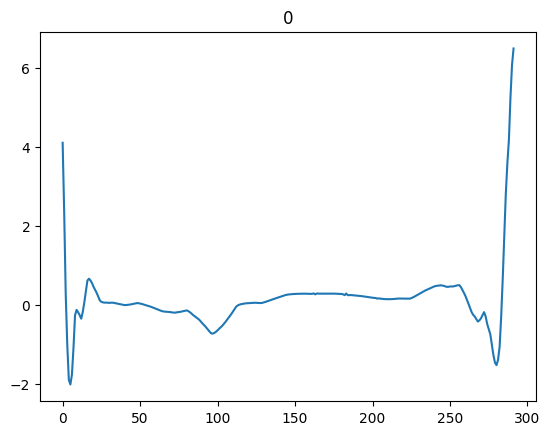

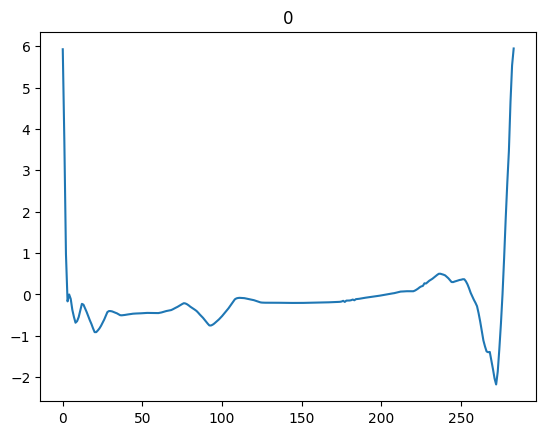

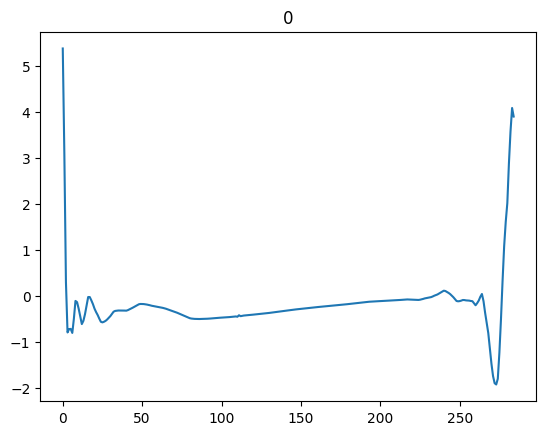

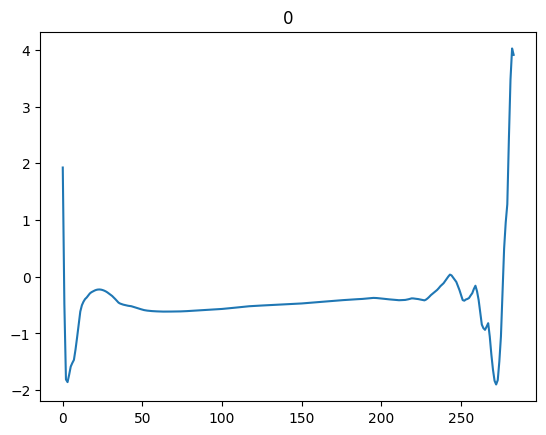

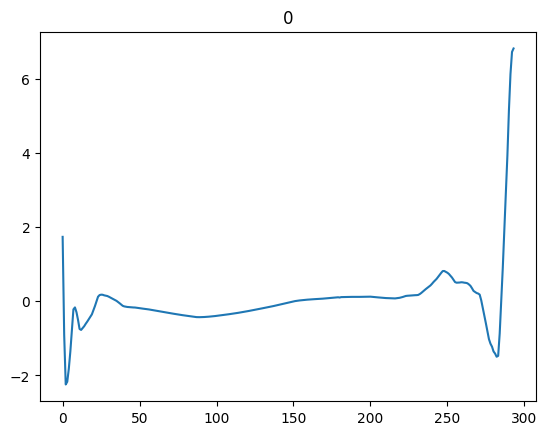

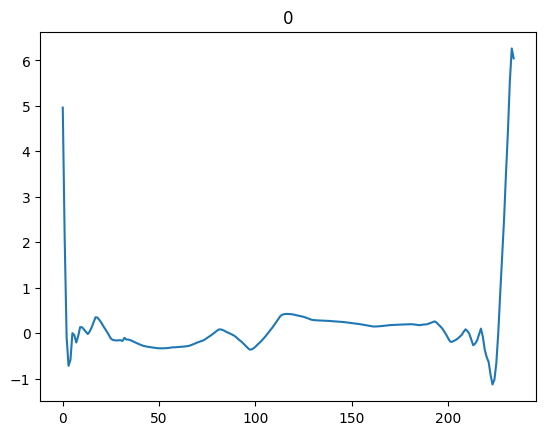

KeyboardInterrupt: 

In [17]:
#loop through the list of annotations
for i in range(1,len(annotations)):
  #set the title to the lable
  plt.title(labels[i])
  #plot the data for the data sections
  plt.plot(datachunk[i]) #dataframe[int(annotations[i][0]):int(annotations[i+1][0])])
  #show the plot
  plt.show()
  #close the plot so we can show the next section
  plt.close()

# plt.plot(dataframe[188561:188904])
# plt.plot(dataframe[188904:189199])
# plt.plot(dataframe[189199:189423])
# ['188561', 'N']
# ['188561', 'N']
# ['188904', 'V']
# ['189199', 'N']
# ['189423', 'N']

## Build the LSTM model
Using the specific model variables of batch_size, epochs, units, input_dim,
sample_size, and time_step.  

In [18]:
#initialize all model specific variables
batch_size = 32                                                                  # make this a number divisible by the total number of samples
epochs = 5
units = 5                                                                        # number of labels
input_dim = 1                                                                    # number of features
sample_size = train_set_datachunk.shape[0]                                       # number of total ECG samples
time_step = train_set_datachunk.shape[1]                                         # length of the ECG chunk
input_shape = (batch_size, time_step, input_dim)

#define the model
model = tf.keras.Sequential([
    #add the layers of the model
    tf.keras.layers.Lambda(lambda x: tf.reshape(x,input_shape)),                 # reshape layer to make the input into LSTM layer 3D -> expected input data shape for LSTM: (batch_size, timesteps, data_dim)
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(batch_size, return_sequences=True, dropout = 0.2)),      # returns a sequence of vectors of dimension batch_size
    tf.keras.layers.LSTM(batch_size, return_sequences=True, dropout = 0.2),      # returns a sequence of vectors of dimension batch_size
    tf.keras.layers.LSTM(batch_size, return_sequences=True, dropout = 0.2),      # returns a sequence of vectors of dimension batch_size
    tf.keras.layers.LSTM(batch_size, return_sequences=True, dropout = 0.2),      # returns a sequence of vectors of dimension batch_size
    tf.keras.layers.LSTM(batch_size, return_sequences=True, dropout = 0.2),      # returns a sequence of vectors of dimension batch_size
    tf.keras.layers.LSTM(batch_size, dropout = 0.2),                             # returns 1xbatch_size
    tf.keras.layers.Dense(units, activation = "softmax")                         # softmax for multiclass labeling

])

#build the model passing int the input shape
model.build((input_shape))

#print the model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (32, 2114, 1)             0         
                                                                 
 lstm_10 (LSTM)              (32, 2114, 32)            4352      
                                                                 
 lstm_11 (LSTM)              (32, 2114, 32)            8320      
                                                                 
 lstm_12 (LSTM)              (32, 2114, 32)            8320      
                                                                 
 lstm_13 (LSTM)              (32, 2114, 32)            8320      
                                                                 
 lstm_14 (LSTM)              (32, 32)                  8320      
                                                                 
 dense_6 (Dense)             (32, 5)                  

Compile the model specifying the loss and optimizer functions and the elvuation metrics for accuracy. Using the sparse categorical crossentropy method for the loss function to achieve multiple numerical matchings of the labels to the ECG singal chunks.

In [19]:
#compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) #loss for numerical and multiple matching

## Train the model by fitting the LSTM model to the train data sets


Save checkpoints during training. Using the tf.keras.callbacks.ModelCheckpoint we can save the model both during and at the end of training.
This allows us to use trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted.

NOTE: it is needed to load in the model to use the saved version.

In [20]:
#initialize variables for the file path and directory of where to save the check points
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Time to train the model with the training data set and assign the output to new variable.

In [21]:
#train the model (where iterations is total num smaples/ batchsize )
train_model = model.fit(train_set_datachunk, train_set_labels, epochs = epochs, batch_size = batch_size, callbacks=[cp_callback])

Epoch 1/5
 286/2501 [==>...........................] - ETA: 3:30:46 - loss: 0.8699 - sparse_categorical_accuracy: 0.7514

KeyboardInterrupt: 

## Test the model

In [49]:
# Loads the weights
model.load_weights(checkpoint_path)

#test the model with a higher batch size
loss, acc = model.evaluate(test_set_datachunk, test_set_labels) # make this a higher batchsize but based on a common factor between test and train set size

307/307 [==============================] - 126s 404ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.7847


In [50]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

In [8]:
#load in the model
new_model = tf.keras.models.load_model('/Users/zoeboysen/Desktop/my_model.keras')       # set safe mode to false to make sure your computer trusts the load

OSError: Unable to open file (file signature not found)

In [ ]:
# Convert the model to a tflite model 
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the model as a tflite for the raspberry pi 
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## Validate the model and show the evaluation metrics

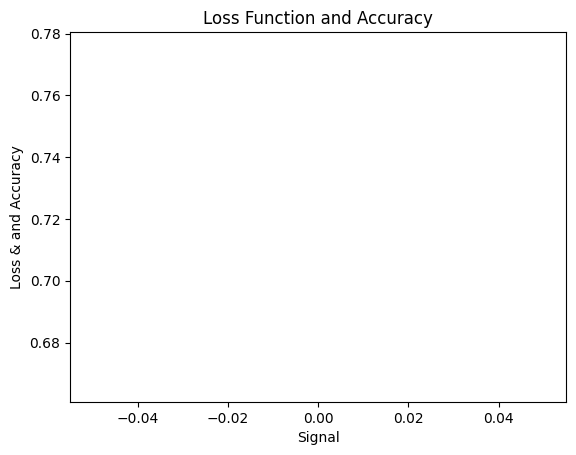

In [27]:
#plot the accuracy and the loss
plt.title("Loss Function and Accuracy")
plt.ylabel("Loss & and Accuracy")
plt.xlabel("Signal")
plt.plot(loss)
plt.plot(acc)
plt.show()

In [40]:
print(loss,acc)
#0.6662784814834595 0.7750407457351685
#0.8470141887664795 0.7600773572921753

0.8470141887664795 0.7600773572921753
